# Koopman kernel models for TC Tracks

[Work in progress]

In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS

In [2]:
from klearn_tcyclone.utils import check_time_steps_TCTracks

### Get data and preprocess

In [3]:
# tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2011), basin='NA', correct_pres=False)
# print('Number of tracks:', tc_tracks.size)

# tc_tracks2 = TCTracks.from_ibtracs_netcdf(provider='official', year_range=(2000, 2011), basin='SA', correct_pres=False)
# print('Number of tracks:', tc_tracks.size)

In [5]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-11-16 08:21:26,361 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


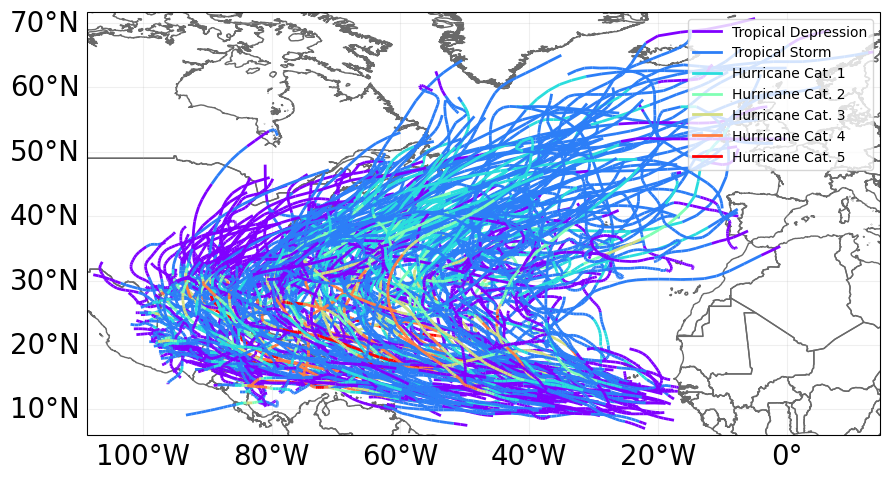

In [3]:
ax = tc_tracks.plot()

In [15]:
time_step_h = 3

In [17]:
tc_tracks.equal_timestep(time_step_h=time_step_h)
check_time_steps_TCTracks(tc_tracks, time_step_h=time_step_h)

np.True_

In [18]:
len(tc_tracks.data)

393

### Spectral analysis, eigenvalues

In [ ]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 2
feature_list = ["lat", "lon", "max_sustained_wind"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [27]:
# scaler = StandardScaler()
scaler = LinearScaler()
# scaler = MinMaxScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (19901, 2, 3): 19901 contexts of length 2 with 3 features each
Test contexts have shape (2151, 2, 3): 2151 contexts of length 2 with 3 features each


In [28]:
check_time_steps_TCTracks(tc_tracks, time_step_h=time_step_h)

np.True_

In [29]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

model = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)

Length scale: 50.0


In [30]:
model = model.fit(contexts["train"])

The rank attribute has been updated to 5.
Consider decreasing the rank parameter.


Plot eigenvalues

In [31]:
eig = model.eig()

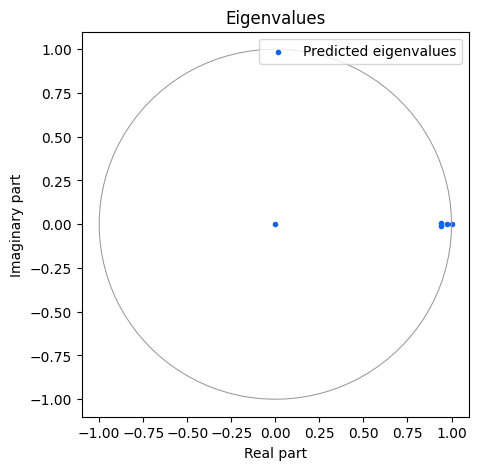

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(eig.real, eig.imag, label='Predicted eigenvalues', marker = '.', color='#0f62fe')
# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), linestyle='-', color='#999', lw=0.75)
ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.set_title('Eigenvalues')
ax.legend(loc=1)
plt.show()

### Comparing spectra vs basins

We compare spectral signatures for different basins and time frequencies of the tropical cyclones.

In [3]:
print(f"Basins are given by {BASINS}.")

Basins are given by ['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA'].


In [16]:
def train_model_evals(tc_tracks_train, tc_tracks_test, context_length, time_lag, feature_list = ["lat", "lon", "max_sustained_wind"], top_k: int = 4):


    tensor_context_train = context_dataset_from_TCTracks(
        tc_tracks_train, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
    )
    tensor_context_test = context_dataset_from_TCTracks(
        tc_tracks_test, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
    )
    contexts = {
        "train": tensor_context_train,
        "test": tensor_context_test,
    }
    scaler = LinearScaler()
    tensor_context_train_transformed = standardize_TensorContextDataset(
        tensor_context_train,
        scaler,
        fit=True,
    )
    tensor_context_test_transformed = standardize_TensorContextDataset(
        tensor_context_test,
        scaler,
        fit=False,
    )

    contexts = {
        "train": tensor_context_train_transformed,
        "test": tensor_context_test_transformed,
    }


    ### Spectral analysis
    # reduced_rank = True
    reduced_rank = False
    rank = 50
    num_centers = 300
    tikhonov_reg = 1e-8

    # Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
    length_scale = 10.0
    kernel = RBF(length_scale=length_scale)
    nys_rrr = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)
    nys_rrr = nys_rrr.fit(contexts["train"])


    # X_pred = nys_rrr.predict(contexts["test"])  # Here we must pass the `X` part of the context
    # X_true = contexts["test"].lookforward(nys_rrr.lookback_len)# This is the `Y` part of the test context
    # rmse_onestep = np.sqrt(np.mean((X_pred - X_true)**2))

    evals = nys_rrr.eig()
    # evals = evals[topk(np.abs(evals), top_k).indices]

    return evals

In [17]:
def time_lag_scaling(basin: str, time_step_h: float, time_lags: list[int], year_range: tuple[int, int] = (2000, 2021), context_length: int =2):
    # Load TCTracks and resample on equal time step.
    tc_tracks = TCTracks.from_ibtracs_netcdf(provider='official', year_range=(2000, 2021), basin=basin)
    print('Number of tracks:', tc_tracks.size)
    tc_tracks.equal_timestep(time_step_h=time_step_h)
    assert check_time_steps_TCTracks(tc_tracks, time_step_h)

    tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
    feature_list = ["lat", "lon", "max_sustained_wind"]    

    # Train model for varying time_lags.
    evals_d = {}
    for time_lag in time_lags:
        print(f"Train for basin {basin} with time_lag {time_lag}.")
        try:
            evals = train_model_evals(tc_tracks_train, tc_tracks_test, context_length, time_lag)
        except:
            evals = None, None,
            print("Not enough time points in some trajectories for given time_lag.")
        evals_d[time_lag] = evals
    
    return evals_d

In [18]:
evals_d = {}
time_step_h = 1
context_length = 13
# context_length = 16
time_lags = range(1, 30, 5)
# time_lags = range(1, 30, 2)
# time_lags = range(1, 50, 5)
basins = BASINS[:-5]
for basin in basins:
    ev_d= time_lag_scaling(basin, time_step_h, time_lags, context_length=context_length)
    evals_d[basin] = ev_d


2024-11-17 21:15:29,091 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-11-17 21:16:34,431 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 2000187N12245, 2000201N11224, 2000203N17249, 2000228N31180.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 438
Train for basin EP with time_lag 1.
Train for basin EP with time_lag 6.
Train for basin EP with time_lag 11.
Train for basin EP with time_lag 16.
Train for basin EP with time_lag 21.
Train for basin EP with time_lag 26.
2024-11-17 21:16:54,465 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393
Train for basin NA with time_lag 1.
Train for basin NA with time_lag 6.
Train for basin NA with time_lag 11.
Train for basin NA with time_lag 16.
Train for basin NA with time_lag 21.
Train for basin NA with time_lag 26.


In [19]:
evals_d.keys()

dict_keys(['EP', 'NA'])

In [20]:
time_lags

range(1, 30, 5)

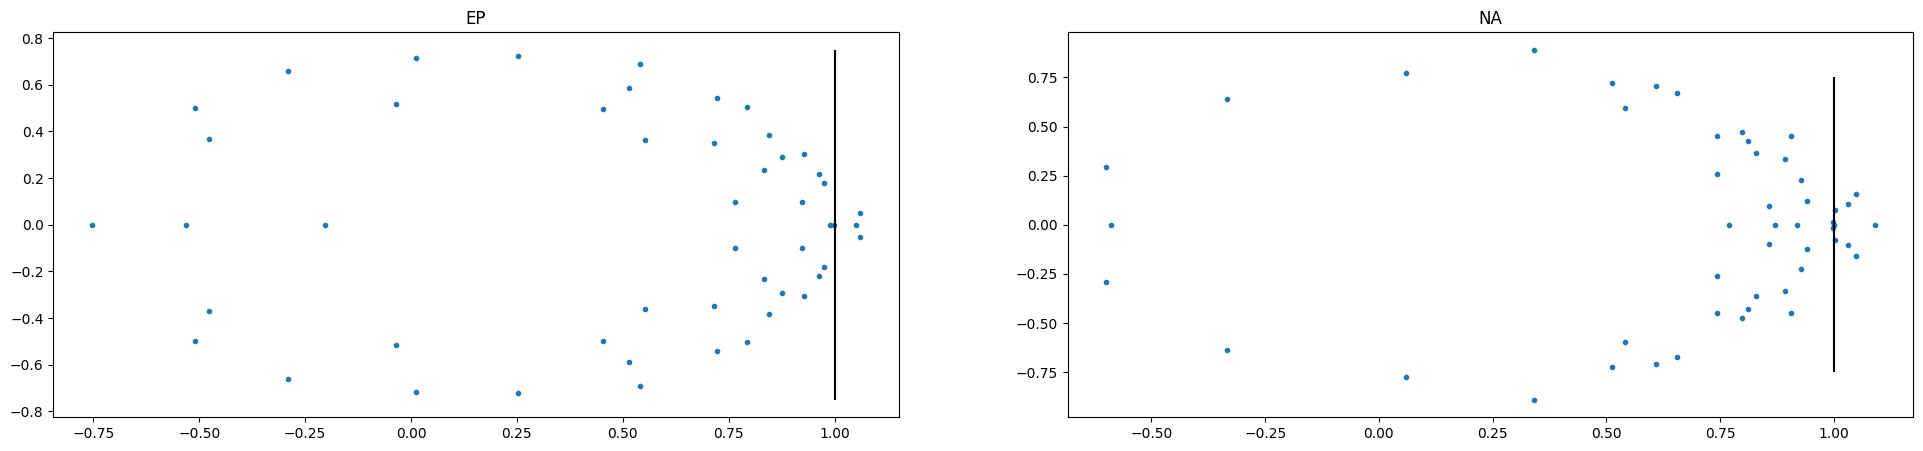

In [25]:
fig, ax = plt.subplots(1, len(basins))
fig.set_size_inches(24, 5)

time_lag = time_lags[3]
for idx, basin in enumerate(basins):
    ax[idx].plot(evals_d[basin][time_lag].real, evals_d[basin][time_lag].imag, ".")
    ax[idx].set_title(basin)
    ax[idx].vlines(1.0, -0.75, 0.75, color="black")


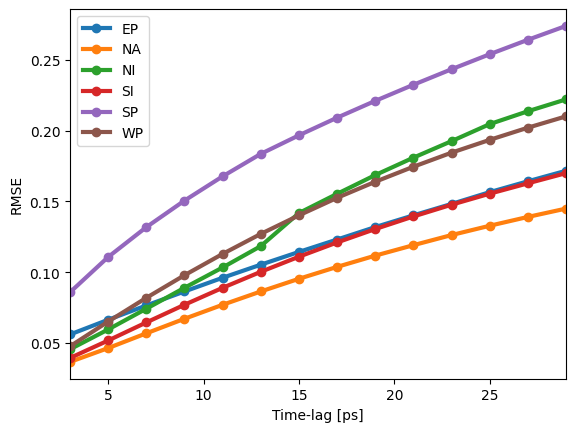

In [106]:
fig, ax = plt.subplots()

basin = BASINS[0]
for basin in BASINS[:-1]:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
ax.margins(x=0)
ax.legend()

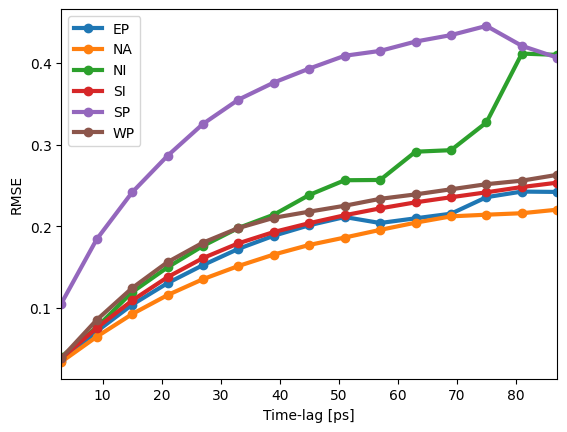

In [110]:
fig, ax = plt.subplots()

basin = BASINS[0]
for basin in BASINS[:-1]:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
ax.margins(x=0)
ax.legend()

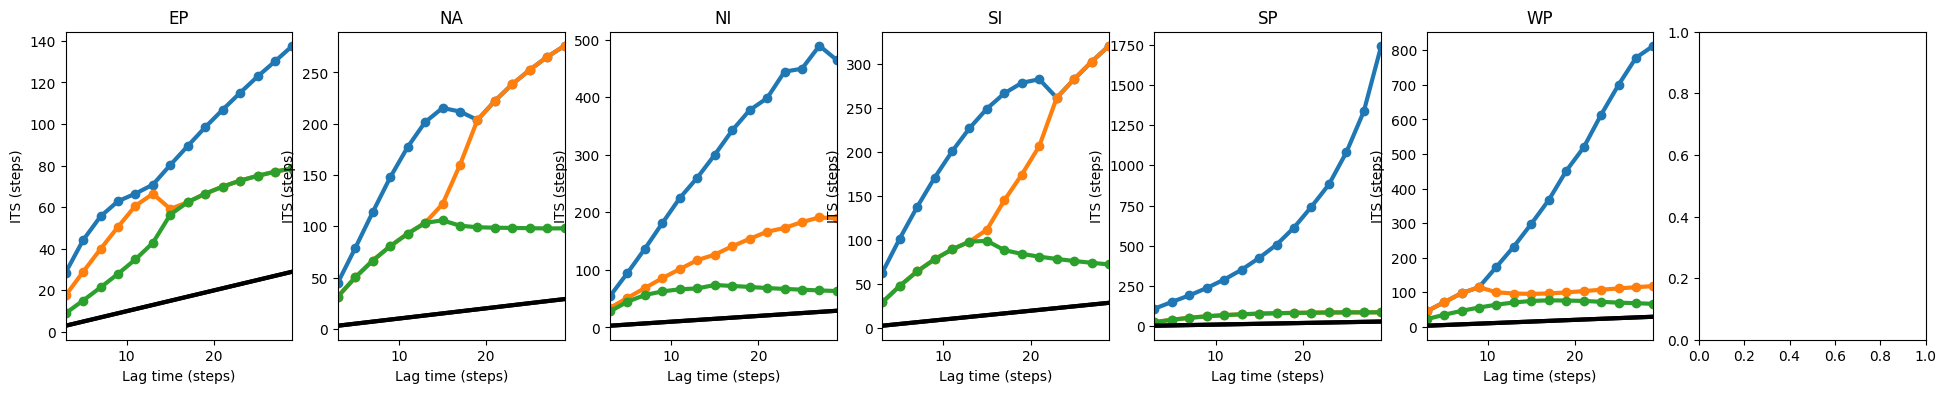

In [108]:
fig, ax = plt.subplots(ncols=len(BASINS), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = BASINS[1]

for idx, basin in enumerate(BASINS[:-1]):

    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

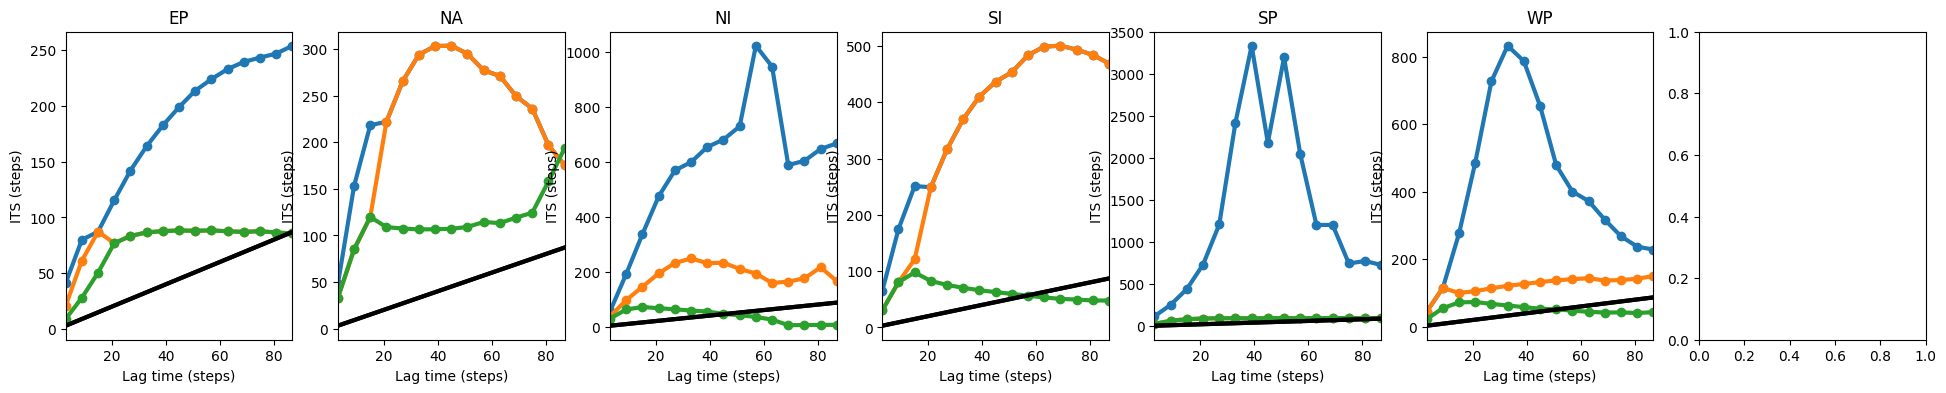

In [112]:
fig, ax = plt.subplots(ncols=len(BASINS), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = BASINS[1]

for idx, basin in enumerate(BASINS[:-1]):

    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

#### Plot eigenfunctions along trajectories

In [82]:
test_dataset = contexts["test"]

In [83]:
top_k = 42
evals, evec_right = model.eig(eval_right_on=test_dataset)
top_evals = topk(np.abs(evals), top_k) # Take the Four largest eigenvalues in modulus
evals = evals[top_evals.indices]
evec_right = evec_right[:, top_evals.indices]

In [84]:
evals.shape, evec_right.shape

((18,), (908, 18))

In [85]:
evals

array([ 0.99993099+0.j        ,  0.99810281+0.01789582j,
        0.99810281-0.01789582j,  0.99284253+0.j        ,
        0.96966378+0.j        ,  0.95157093+0.j        ,
        0.92774601+0.j        ,  0.91192916+0.11948172j,
        0.91192916-0.11948172j,  0.84056807+0.17061753j,
        0.84056807-0.17061753j,  0.80860608+0.j        ,
        0.4659339 +0.03439862j,  0.4659339 -0.03439862j,
        0.31285702+0.j        ,  0.08403348+0.j        ,
        0.01126608+0.j        , -0.00254642+0.j        ])

In [86]:
test_dataset.shape

(908, 42, 3)

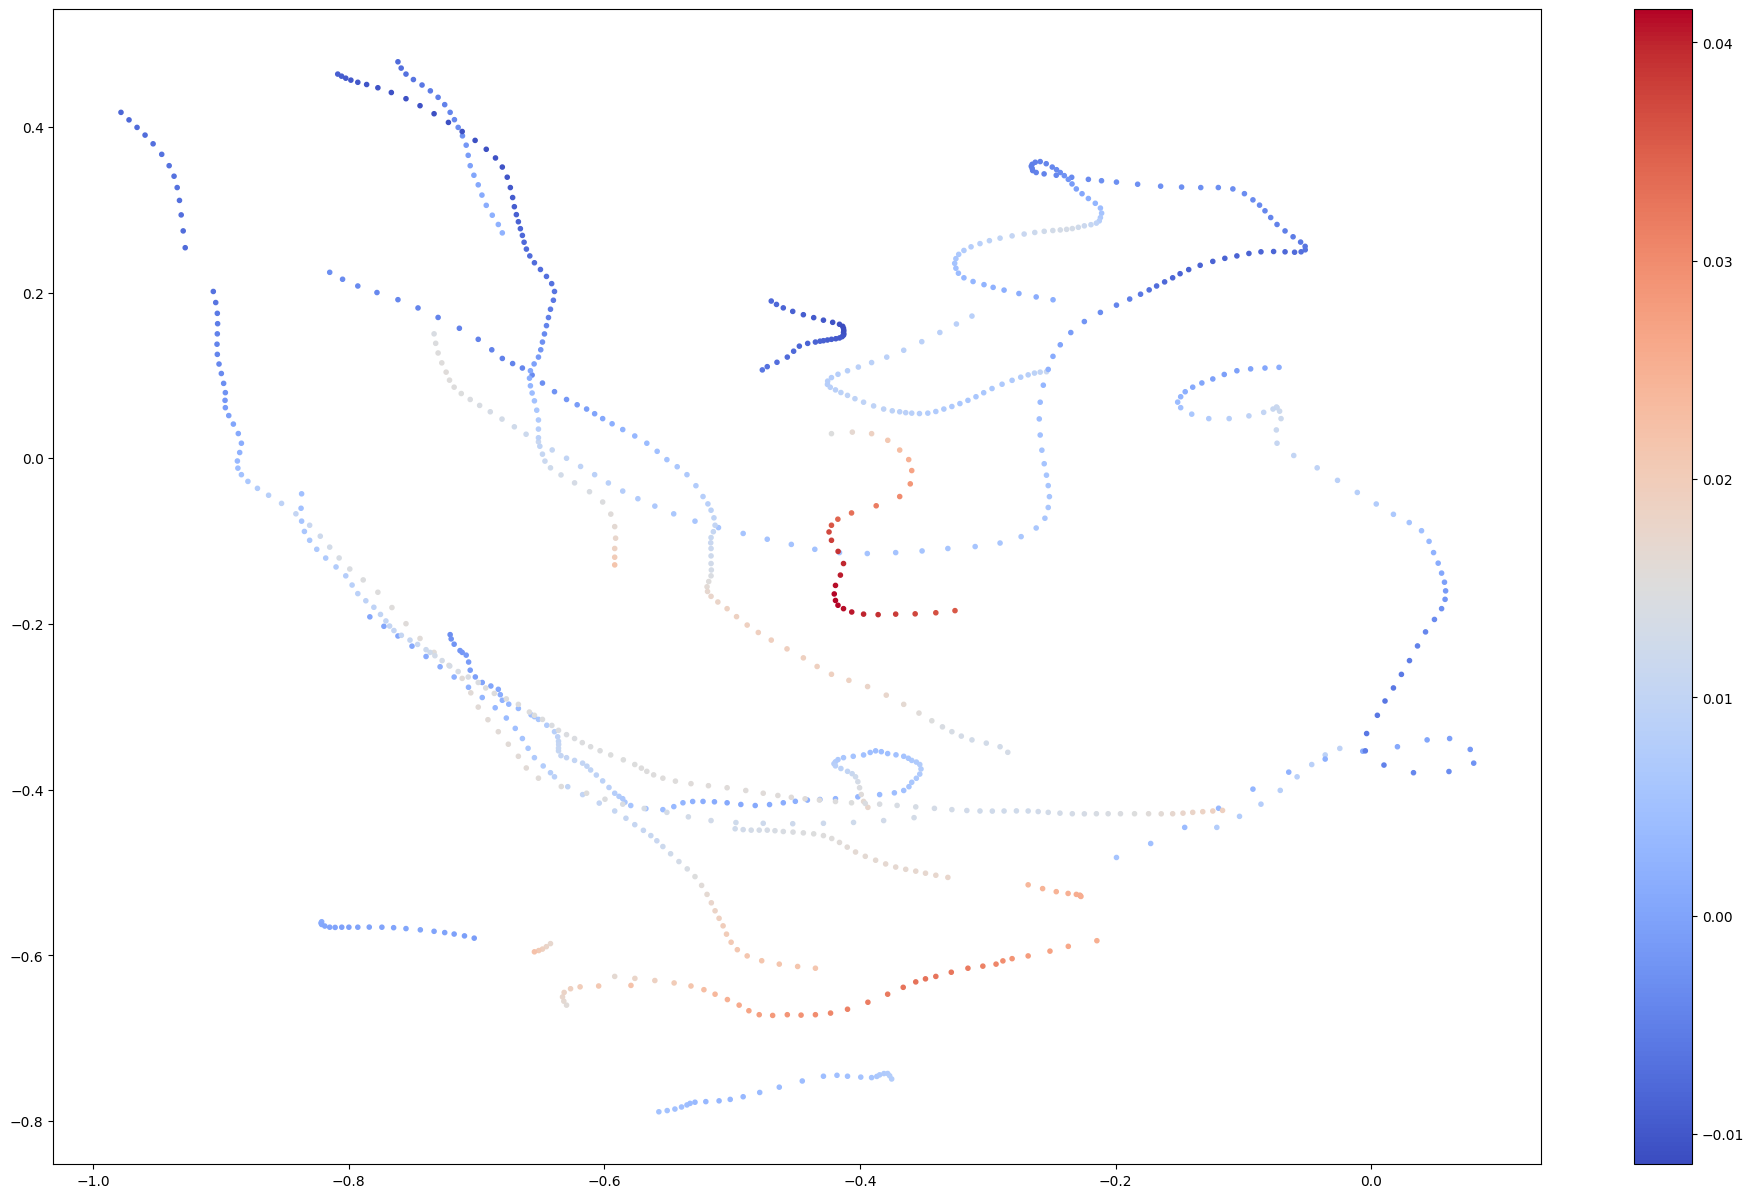

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 15)

idx = -1
evec_idx = 1

cmap = plt.cm.coolwarm

plt.scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = evec_right[:idx, evec_idx])
plt.colorbar()

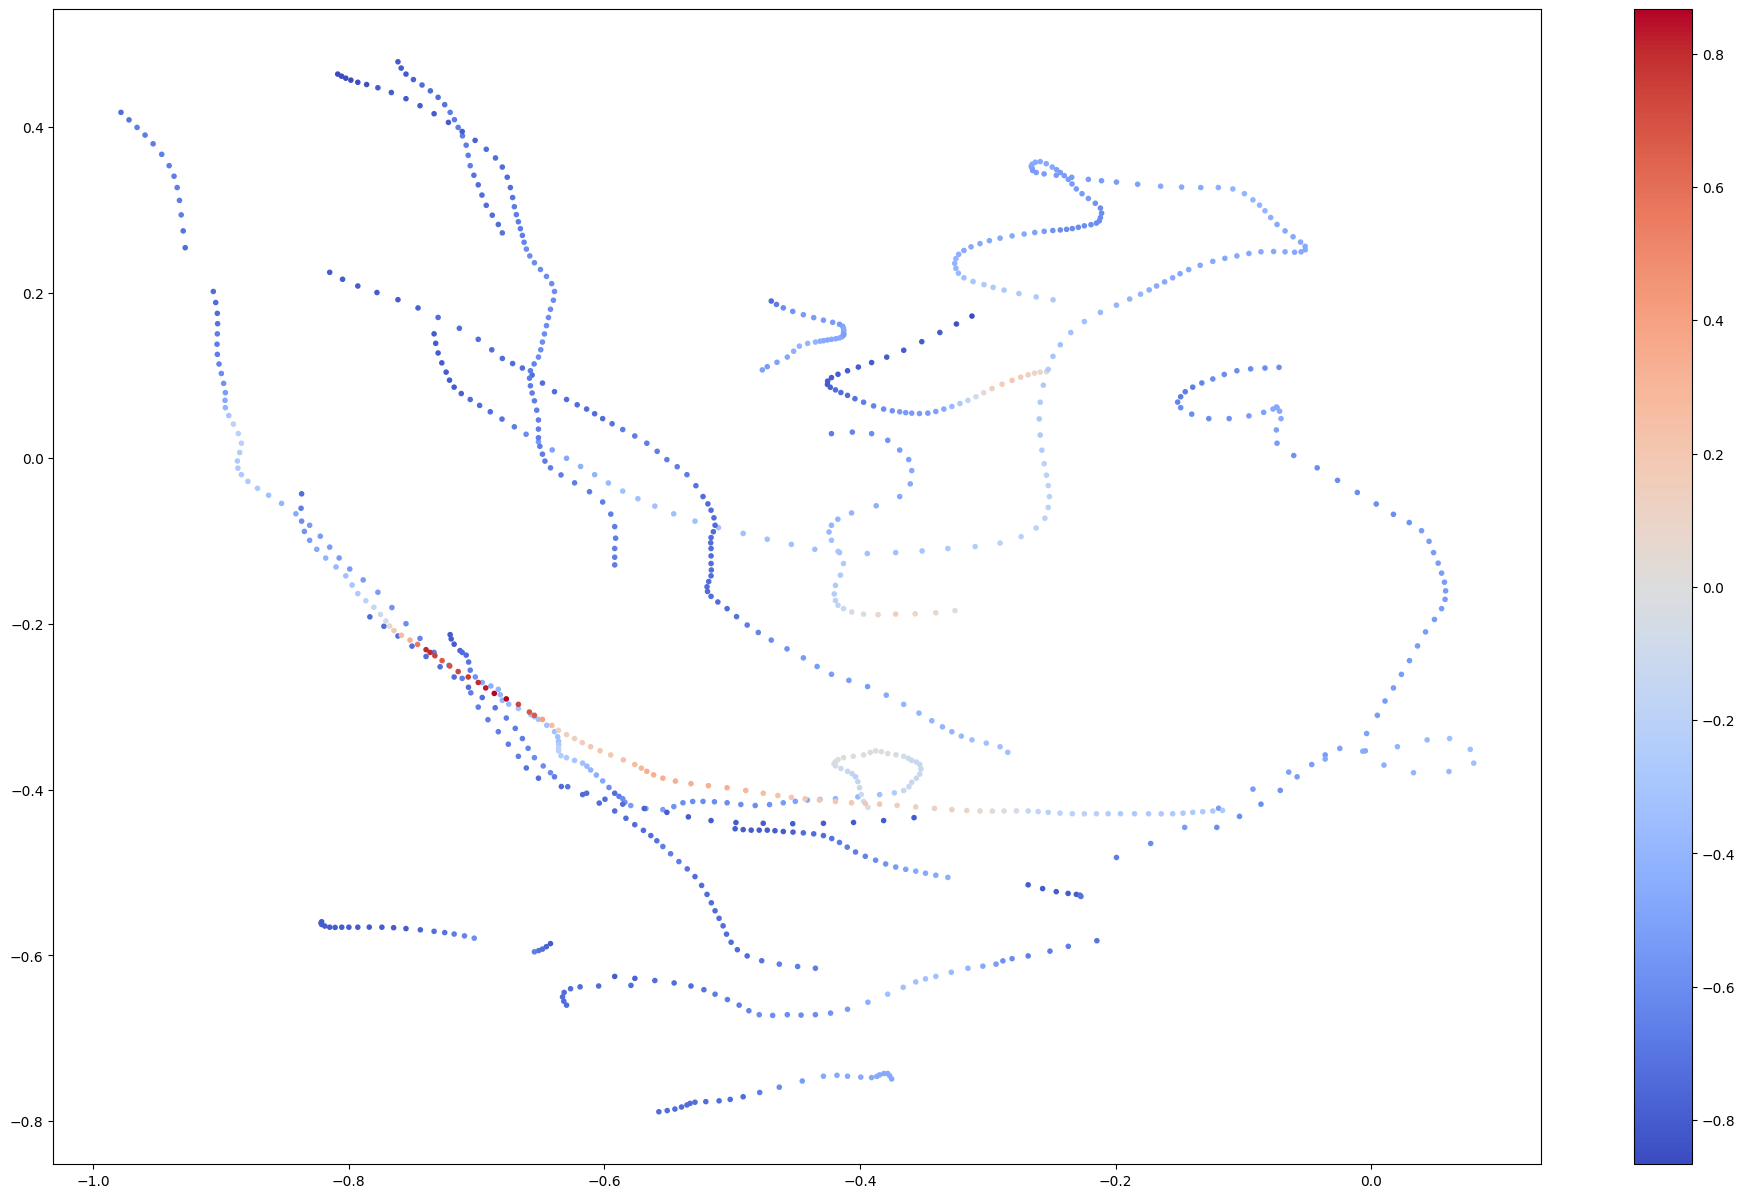

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 15)

idx = -1

cmap = plt.cm.coolwarm

plt.scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = test_dataset.data[:idx, 0, 2])
plt.colorbar()